In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
basedir = "/Users/bono/Desktop/gm2FieldAnalysis/MuonConvolution/"

# First verify that the DQM removes field spikes

In [2]:
path = basedir + 'synthesis/data/60H_field_ctag_dqm.pkl'
df = pd.read_pickle(path)

/usr/local/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


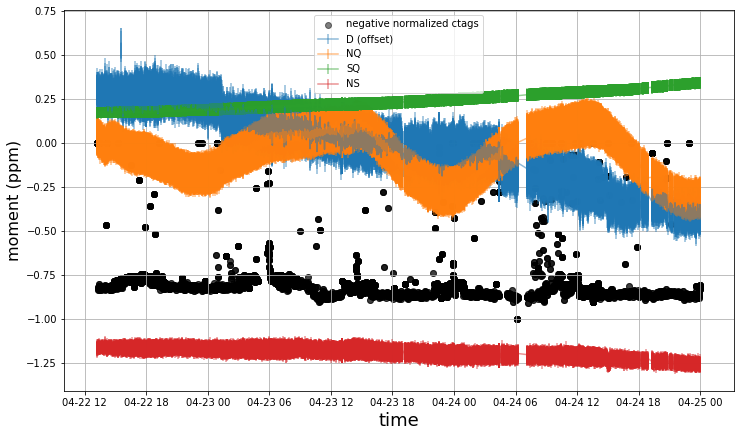

In [3]:
#for plotting together, subtract the dipole average from the dipole
mean = df['D'].mean()
df['Doff'] = df['D'] - mean
ctag_mean = df['ctags'].max()
df['ctags_norm'] = df['ctags']/ctag_mean

#plot the moments together
fig = plt.figure(figsize=(12,7))
plt.errorbar(df['start_time'], df['Doff'], 
             yerr=df['eD'], label='D (offset)',alpha=0.5)
plt.errorbar(df['start_time'], df['NQ'], 
             yerr=df['eNQ'], label='NQ',alpha=0.5)
plt.errorbar(df['start_time'], df['SQ'],
             yerr=df['eSQ'], label='SQ',alpha=0.5)
plt.errorbar(df['start_time'], df['NS'], 
             yerr=df['eNS'], label='NS',alpha=0.5)
plt.scatter(df['start_time'], -df['ctags_norm'], 
            label='negative normalized ctags',alpha=0.5,color='black')

plt.grid()
plt.xlabel('time', fontsize=18)
plt.ylabel('moment (ppm)', fontsize=16)
plt.legend()

plt.show()

Below we verify that the field has spike when the dqm is not applied

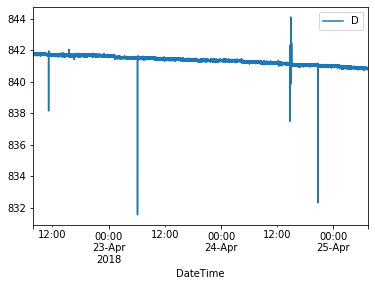

In [4]:
path = basedir + 'field_info/'
sys.path.insert(0,path)
from format_field import get_field_df
from format_field import field_team_to_standard_moments as ftts
from field_grid import *
path=path+'data/'
file = path+"60Hr_Average_Comparison_all_3956_3997_norescut_NoAvg.txt"
file
df_poor_field = get_field_df(file)
df_poor_field.reset_index(inplace=True)
df_poor_field.plot('DateTime',"D")

In [5]:
print(df_poor_field['D'].mean(),'\n')
print(df_poor_field['NQ'].mean(),'\n')
print(df_poor_field['SQ'].mean(),'\n')
print(df_poor_field['NS'].mean(),'\n')


841.3592696523522 

-0.05186266397026656 

0.24828763239450855 

-1.1950317958425325 



# Now compute the ctag weighted field and error

In [6]:
#add the var from the error
df['varD'] = df['eD']**2
df['varNQ'] = df['eNQ']**2
df['varSQ'] = df['eSQ']**2
df['varNS'] = df['eNS']**2

#field
total_ctags = df["ctags"].sum()
b = [
    (df["D"]*df["ctags"]).sum()/total_ctags,
    (df["NQ"]*df["ctags"]).sum()/total_ctags,
    (df["SQ"]*df["ctags"]).sum()/total_ctags,
    (df["NS"]*df["ctags"]).sum()/total_ctags
    ]

#var of field
b_var = [
    (df["varD"]*df["ctags"]).sum()/total_ctags,
    (df["varNQ"]*df["ctags"]).sum()/total_ctags,
    (df["varSQ"]*df["ctags"]).sum()/total_ctags,
    (df["varNS"]*df["ctags"]).sum()/total_ctags
    ]
#error on field
b_err = [np.sqrt(v) for v in b_var]

#a slighly incorrect way to calculate error on field (for comparison)
b_err_bad = [
    (df["eD"]*df["ctags"]).sum()/total_ctags,
    (df["eNQ"]*df["ctags"]).sum()/total_ctags,
    (df["eSQ"]*df["ctags"]).sum()/total_ctags,
    (df["eNS"]*df["ctags"]).sum()/total_ctags
    ]

print(b,'\n')
print(b_err,'\n')
print(b_err_bad,'\n')

[841.413353362968, -0.009484349988511841, 0.23283668185181491, -1.184209108412721] 

[0.12277434991428353, 0.11551575427058625, 0.0342516080015289, 0.0471781251886569] 

[0.1220826558079622, 0.11536597297419726, 0.034229377945099254, 0.0470350329621386] 



In [7]:
#convert to standard moments convention
from format_field import field_team_to_standard_moments as ftts
c,s = ftts(b)
ec,es = ftts(b_err)

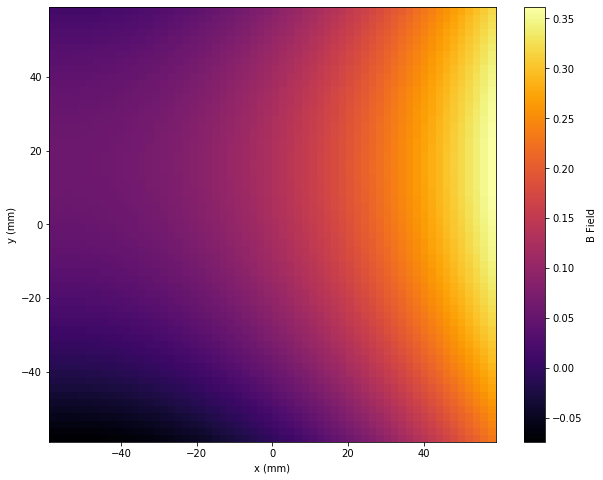

In [8]:
#plot the field error
df_field_grid_err = get_field_grid(b_err)
fig = plot_field(df_field_grid_err)
fig

## Get the muon moments

In [11]:
path= basedir + 'tracker_info'
sys.path.append(path)
from beam_moments import *
from transform_beam import *
from beam_moments import get_normalized_distribution_moments as gndm

In [12]:
df_tracker = get_df_tracker()
mask12 = (df_tracker["Station"] == 'station12')
df_12 = df_tracker[mask12].copy()
df_12['counts_norm'] = df_12['counts']/df_12['counts'].sum()

#
x = df_12['radial']
y = df_12['vertical']
weights = df_12['counts']
N = 3
I_norm, J_norm = gndm(N,x,y,weights)

In [13]:
print(c,'\n')
print(s,'\n')
print(I_norm,'\n')
print(J_norm,'\n')

[ 8.41413353e+02 -9.48434999e-03 -1.18420911e+00] 

[0.         0.23283668 0.        ] 

[1.         0.15097058 0.10640059] 

[ 0.         -0.00012891  0.00056273] 



In [14]:
print(c*I_norm,'\n')
print(s*J_norm,'\n')

[ 8.41413353e+02 -1.43185781e-03 -1.26000550e-01] 

[ 0.00000000e+00 -3.00142634e-05  0.00000000e+00] 



In [19]:
# print(ec,es)

print(ec*I_norm,'\n')
print(es*J_norm,'\n')

[0.12277435 0.01743948 0.00501978] 

[ 0.00000000e+00 -4.41526986e-06  0.00000000e+00] 



### show the time averaged field multipoles

In [15]:
print(df['D'].mean())
print(df['NQ'].mean())
print(df['SQ'].mean())
print(df['NS'].mean())

841.4067761652245
-0.01784907072725138
0.2343025313052377
-1.1852738780351662
